<a href="https://colab.research.google.com/github/electropavuk/crypto_trader/blob/master/ipynb/BollingerBands.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# !pip install python-dotenv python-binance 

In [111]:
import os
import datetime
import random
from itertools import product

from dotenv import load_dotenv
from binance import Client
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np



pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)
pd.set_option('display.width', 1000)

np.set_printoptions(edgeitems=10, linewidth=200)
pd.options.mode.chained_assignment = None 

google_drive_dir = '/content/drive/MyDrive/Colab Notebooks/crypto_trader/'
data_dir = google_drive_dir + 'data/'
load_dotenv(google_drive_dir + '.env')

api_key = os.getenv('READONLY_API_KEY')
secret_key = os.getenv('READONLY_SECRET_KEY')

client = Client(api_key, secret_key)

In [112]:
# def get_history(symbol, interval, period):
#     base, quote = 'BTC', 'USDT'
#     klines = client.get_historical_klines(symbol=symbol, interval=interval, start_str= period + ' ago UTC')
#     labels = ['Open time', 'Open', 'High', 'Low', 'Close', 
#     		  base + ' volume', 'Close time', quote + ' volume', 'Number of trades',
#     		  f'{base} buy volume', f'{quote} sell volume', 'Ignore']
#     df = pd.DataFrame(data=klines, columns=labels, dtype=float)
#     return df

def load_history(filename):
    return pd.read_csv(data_dir + filename)


history = load_history('1h.csv')

In [113]:
def prepare_data(df, period=20, mult=2):
    df = df[['Close']]

    df['median'] = df['Close'].rolling(period).mean()
    df['std'] = df['Close'].rolling(period).std() * mult
    df['upper'] = df['median'] + df['std']
    df['lower'] = df['median'] - df['std']

    df = df.dropna()
    
    return df

In [114]:
def simulate(model, data, n, money=100, commision=0.00075):

    trades = []
    init_money = balance = money
    clean = 1 - commision
    quantity = 0

    for t in range(-n, -1):
        action = model(data, t)
        price = data['Close'].iloc[t]
        if action == 'buy' and balance > 0:
            buy_price = price
            quantity = clean * balance / price
            balance = 0
            trades.append(('buy', t, price, balance))
        elif action == 'sell' and quantity > 0:
            balance = clean * quantity * price
            trades.append(('sell', t, price, balance))
            quantity = 0
    
    if quantity > 0:
        balance += quantity * buy_price
        trades.pop()
    
    profit = (balance - init_money) / init_money
    return trades, profit

In [115]:
def config_plot(plt):
    plt.figure(figsize = (30, 5))
    plt.xlim((-n, 0))
    plt.grid(True)

def show_graph(data, trades):
    xsell, ysell, xbuy, ybuy = [], [], [], []
    for action, t, price, _ in trades:
        if action == 'buy':
            xbuy.append(t)
            ybuy.append(price)
        if action == 'sell':
            xsell.append(t)
            ysell.append(price)

    config_plot(plt)

    # BB
    plt.plot(range(-n, 0), data['median'].iloc[-n:], label='median', c='grey')
    plt.plot(range(-n, 0), data['upper'].iloc[-n:], label='upper', c='green')
    plt.plot(range(-n, 0), data['lower'].iloc[-n:], label='lower', c='green')

    # Price and trades
    plt.title('{} trades made, profit {:.1f} %'.format(len(trades), profit * 100))
    plt.plot(range(-n, 0), data['Close'].iloc[-n:], label='Closing price', c='black')
    plt.scatter(xbuy, ybuy, label='Buy', c='blue')
    plt.scatter(xsell, ysell, label='Sell', c='red')
    
    plt.legend()



def show_profit(data, trades):
    config_plot(plt)
    xprofit, yprofit = [], []
    balance = init_money = money
    for action, t, price, balance in trades:
        if balance > 0:
            xprofit.append(t)
            yprofit.append(100 * (balance - init_money) / init_money)


    plt.title('Profit')
    plt.plot(xprofit, yprofit, label='Profit', c='black', linestyle=':')
    plt.legend()

In [116]:
class BBLowHigh:
    def __init__(self, patience=1, max_hold=10**6):
        self.patience = patience
        self.max_hold = max_hold
        self.cur_hold = 0
        self.bought = False


    def __call__(self, data, t):
        close = data['Close'].iloc[t - self.patience: t + 1].values
        median = data['median'].iloc[t - self.patience: t + 1].values
        upper = data['upper'].iloc[t - self.patience: t + 1].values
        lower = data['lower'].iloc[t - self.patience: t + 1].values

        if self.bought:
            self.cur_hold += 1

        if all(close < lower) and not self.bought:
            self.bought = True
            return 'buy'
        elif all(close > upper) or self.cur_hold == self.max_hold:
            self.bought = False
            self.cur_hold = 0
            return 'sell'
        else:
            return 'wait'

In [117]:
def search_parameters(period, mult):
    params = product(period, mult)

    profits = []
    for period, mult in params:
        data = prepare_data(history, period, mult)
        trades, profit = simulate(model, data, n, money=money, commision=0.00075)
        print('params {} : profit = {:.1f} %'.format((period, mult), profit * 100))
        profits.append((profit, (period, mult)))

    profit, (period, mult) = max(profits)
    print('BEST')
    print('params {} : profit = {:.1f} %'.format((period, mult), profit * 100))
    return period, mult

period 23, patience 1, mult 2.6, profit 236.49615289430136 %


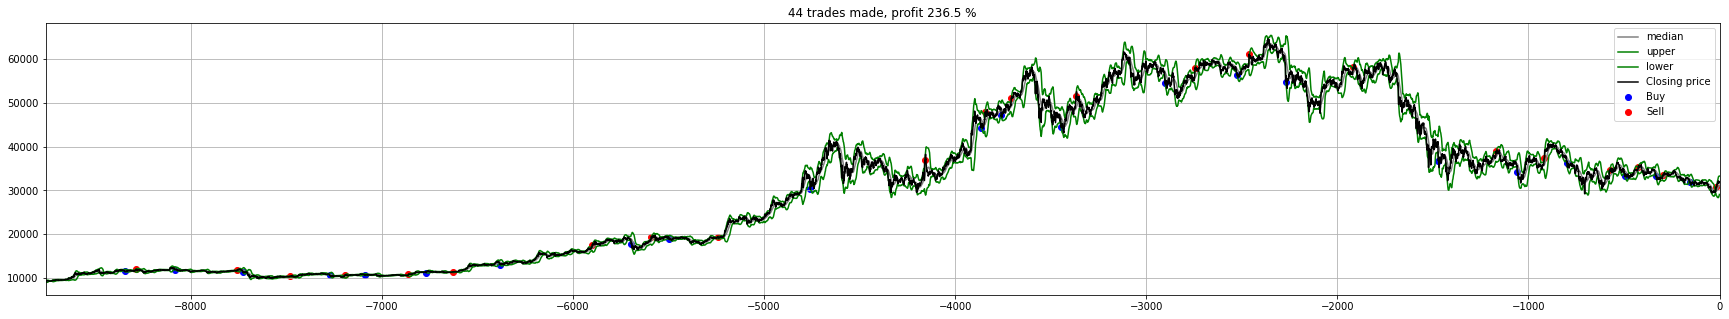

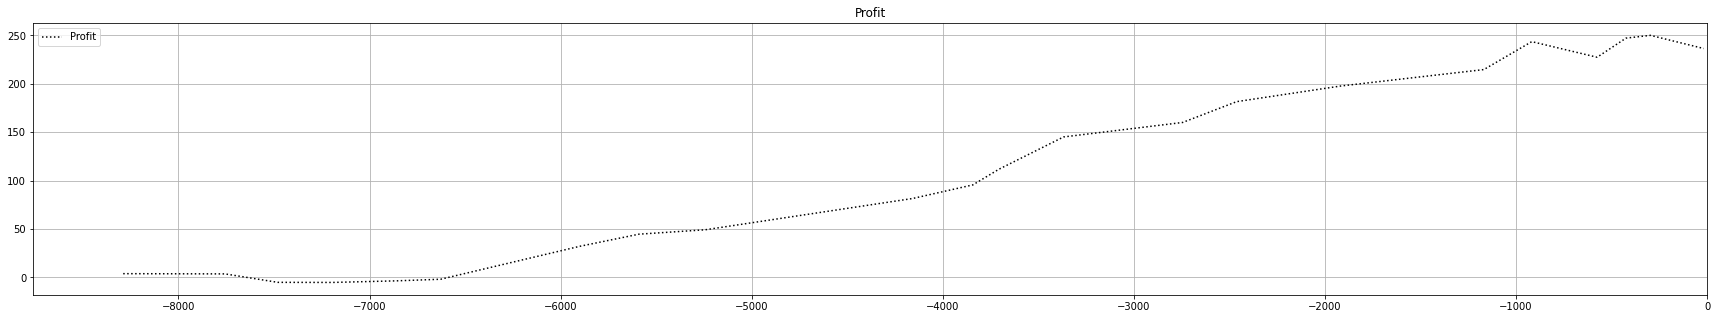

In [123]:
money = 100
n = 24 * 365

patience = 1
period, mult = (23, 2.6)


# period, mult = search_parameters(range(15, 33, 2), [1.6, 1.8, 2, 2.2, 2.4, 2.6, 2.7, 2.8, 2.9])
data = prepare_data(history, period=period, mult=mult)

model = BBLowHigh(patience=patience)

trades, profit = simulate(model, data, n, money=money, commision=0.00075)

print(f'period {period}, patience {patience}, mult {mult}, profit {profit * 100} %')

show_graph(data, trades)
show_profit(data, trades)